In [2]:
import sys
print(sys.executable)

c:\Users\joshu\AppData\Local\Programs\Python\Python313\python.exe


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [3]:
df = pd.read_csv('cisplatin.csv')
df

,Unnamed: 0,drug,cell_line,log10_dose,viability
0,1,CISPLATIN,924238,-2.397711,0.972837
1,2,CISPLATIN,924238,-2.221620,1.000000
2,3,CISPLATIN,924238,-1.897749,0.947334
3,4,CISPLATIN,924238,-1.721658,1.000000
4,5,CISPLATIN,924238,-1.408240,0.931629
...,...,...,...,...,...
19509,19510,CISPLATIN,908441,-0.221772,0.923064
19510,19511,CISPLATIN,908441,0.102098,1.000000
19511,19512,CISPLATIN,908441,0.278189,0.622700
19512,19513,CISPLATIN,908441,0.602060,0.847234


In [20]:
def preprocess_data(df, cell_line_indices):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]
    
    unique_cell_lines = df_copy['cell_line'].unique()
    selected_cell_lines = unique_cell_lines[cell_line_indices]  # Select by indices
    
    df_subset = df_copy[df_copy['cell_line'].isin(selected_cell_lines)]
    
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')
    
    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)
    
    return x, Y.T

list_cell_lines = [3, 13, 15, 29]
x, Y = preprocess_data(df, list_cell_lines)

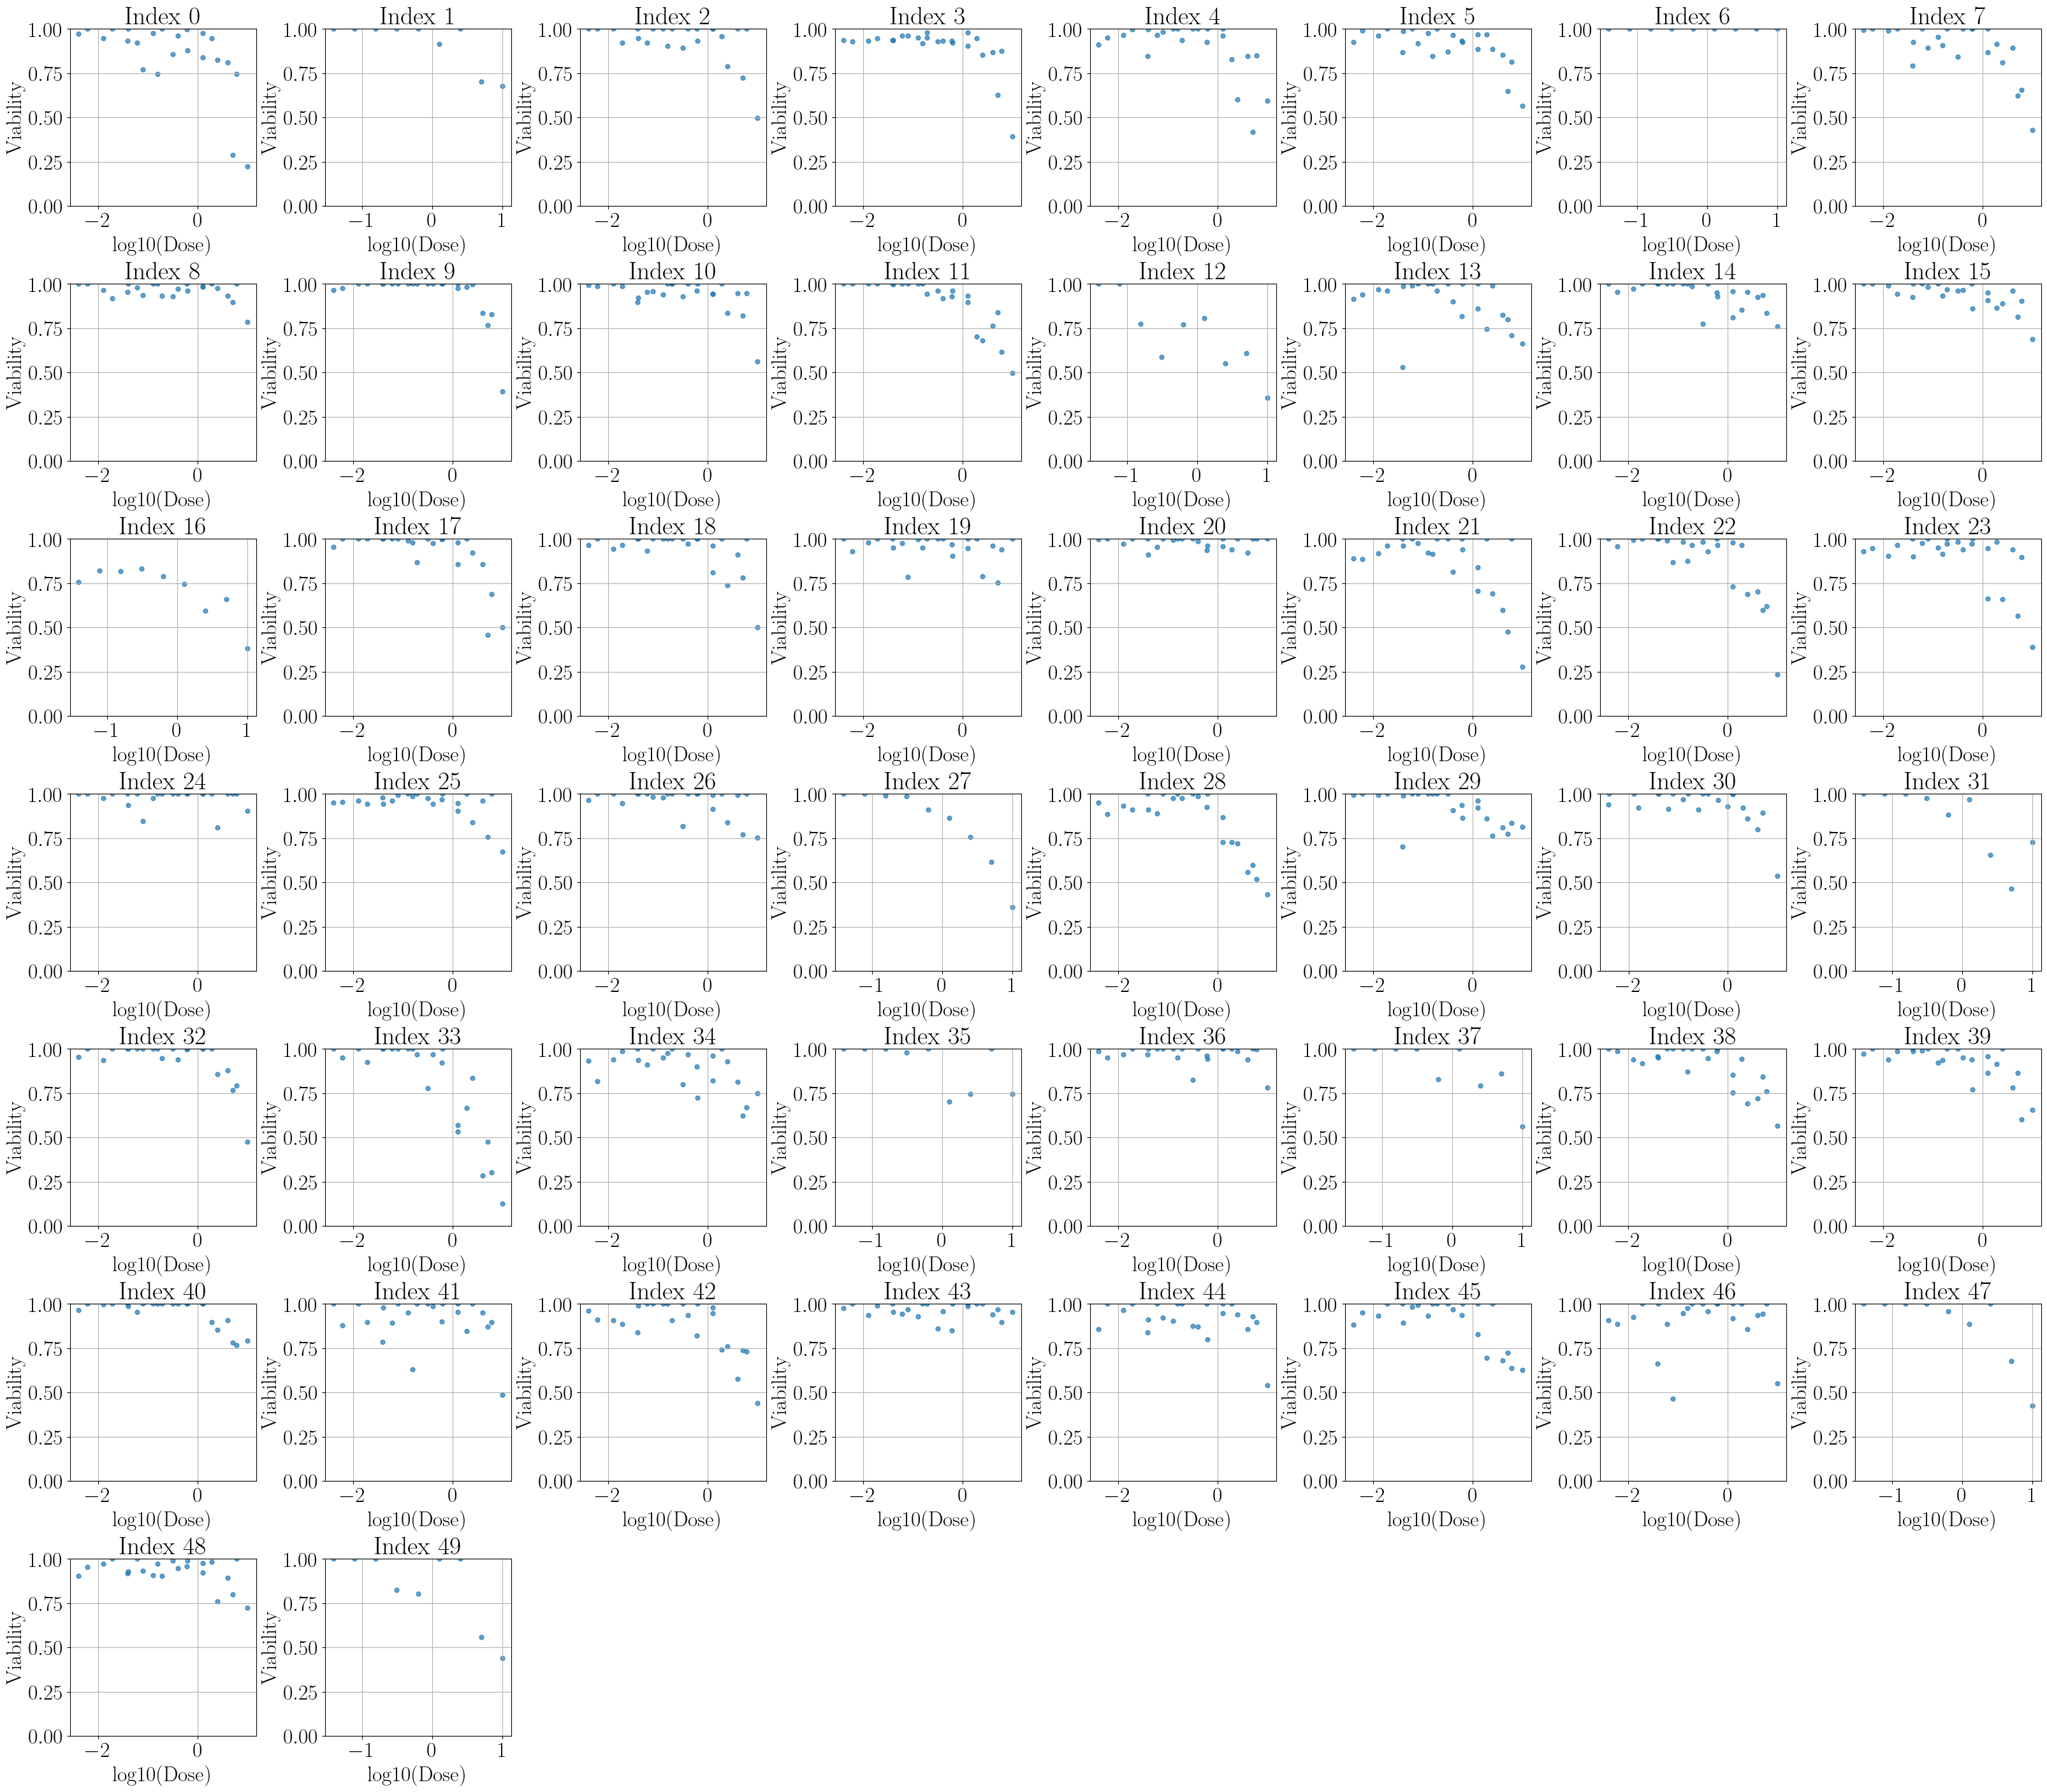

In [10]:
def visual_examples(df, k):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Index {i}')
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(0, 1)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 50)

Optimized length_scale: 1.8664, noise: 0.006538
Optimized A: [[ 0.37367918 -0.01245993  0.07733598  0.0875186 ]
 [ 0.3587689  -0.01196237  0.0742508   0.08402664]
 [ 0.3536112  -0.01179071  0.07318329  0.08281889]
 [ 0.38753254 -0.01292191  0.08020358  0.09076344]]
Optimized B: 
[[0.15343174 0.14730967 0.14519195 0.15911996]
 [0.14730967 0.14143188 0.13939866 0.15277093]
 [0.14519195 0.13939866 0.13739466 0.15057469]
 [0.15911996 0.15277093 0.15057469 0.16501906]]


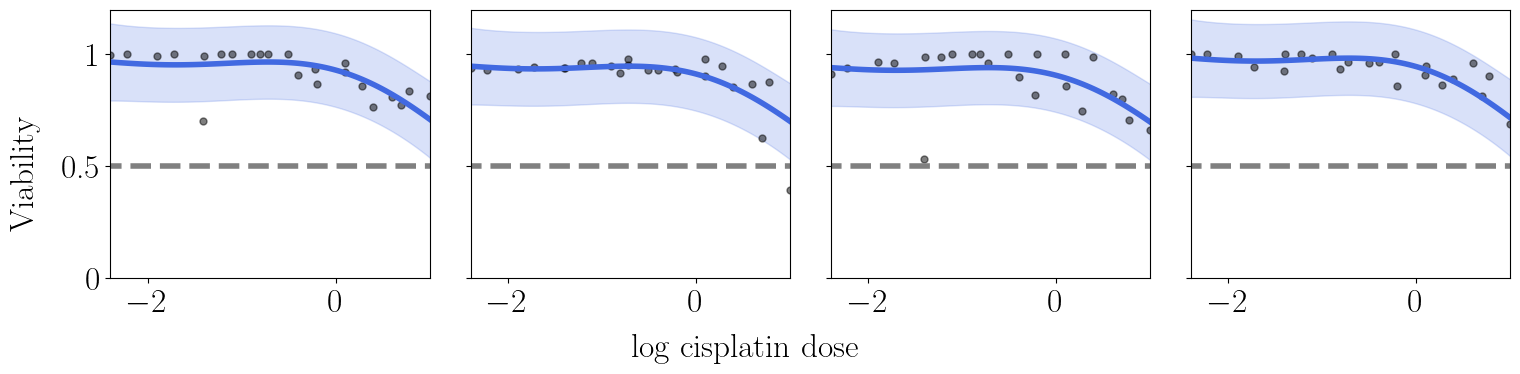

In [ ]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = 0.1
init_A = np.array([[1, 0, 0, 0],
                   [0.8, 0.6, 0, 0],
                   [0.8, 0.2666, 0.5375, 0],
                   [0.8, 0.2666, 0.16538, 0.5114]
                   ])

# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
mogp.fit(x, Y)

# Optimize hyperparameters
mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()